In [1]:
%pip install siphon -q


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import requests
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import odc.geo

from pyproj import CRS
from bs4 import BeautifulSoup
from odc.geo.xr import assign_crs
from odc.geo.geobox import GeoBox
from affine import Affine
from siphon.catalog import TDSCatalog

import sys

sys.path.insert(1, "home/jovyan/dev/Tools/")
from dea_tools.plotting import rgb
from dea_tools.dask import create_local_dask_cluster


In [ ]:
client = create_local_dask_cluster(return_client=True)


<Client: 'tcp://127.0.0.1:34315' processes=1 threads=31, memory=237.21 GiB>

2025-08-21 04:47:04,615 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:36377' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('store-map-74f71552df4ddf4b4e3d198917f1836e', 0, 2, 1), ('reproject-store-map-74f71552df4ddf4b4e3d198917f1836e', 0, 0, 3)} (stimulus_id='handle-worker-cleanup-1755751624.6145132')
2025-08-21 04:47:04,631 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36377'.
2025-08-21 04:47:23,639 - distributed.nanny - WARNING - Worker process still alive after 4.0 seconds, killing


## MODIS CRS and tile info


In [ ]:
# Define MODIS Sinusoidal projection
modiscrs = CRS.from_proj4("+proj=sinu +R=6371007.181 +nadgrids=@null +wktext")

# the tiles are from over Australia
au_tiles = [
    "h27v11",
    "h27v12",
    "h28v11",
    "h28v12",
    "h28v13",
    "h29v10",
    "h29v11",
    "h29v12",
    "h29v13",
    "h30v10",
    "h30v11",
    "h30v12",
    "h31v10",
    "h31v11",
    "h31v12",
    "h32v10",
    "h32v11",
]


## Analysis params

In [ ]:
years = ["2024"]
resolution = 0.005  # 500m resolution


In [ ]:
save_path = "/home/jovyan/gdata1/projects/fc-sub-annual/data/modis-fc/"

vector_path = (
    "/home/jovyan/gdata1/projects/fc-sub-annual/australia_100km_buffer.geojson"
)

catalog = (
    "https://thredds.nci.org.au/thredds/catalog/tc43/modis-fc/v310/tiles/monthly/cover/"
)
data_link = (
    "https://thredds.nci.org.au/thredds/dodsC/tc43/modis-fc/v310/tiles/monthly/cover/"
)


## Set up a geobox around Australia

In [ ]:
# we will reproject to this after merging all the tiles
lat_max = -10.0
lat_min = -45.0
lon_max = 155.0
lon_min = 111.0

width = int((lon_max - lon_min) / resolution)
height = int((lat_max - lat_min) / resolution)

transform = [
    lon_min - resolution / 2,
    resolution,
    0.0,
    lat_max + resolution / 2,
    0.0,
    -1 * resolution,
]
affine = Affine.from_gdal(*transform)
geobox = GeoBox((height, width), affine, "EPSG:4326")


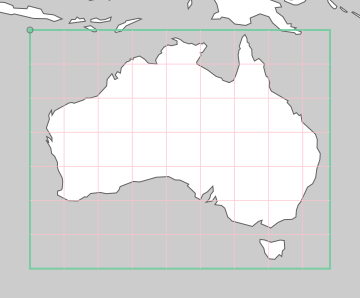

In [ ]:
geobox


In [ ]:
modis_cat = TDSCatalog(catalog)


In [ ]:
ds = xr.open_dataset(modis_cat.datasets[0].access_urls["OPENDAP"], chunks="auto")

# print(ds.attrs)


In [ ]:
print(modis_cat.datasets[0])


FC_Monthly_Medoid.v310.MCD43A4.h00v08.2001.006.nc


If I make too many requests at once, thredds blocks them. So instead of making a single mosaic, I am going to need to save each tile as a .nc in gdata and then mosaic them afterwards I think.

In [ ]:
# get files where listed tile intersects with AU list
modis_tiles = []

for i in range(len(modis_cat.datasets)):
    tile_save_path = os.path.join(save_path, "tiles")
    tile_name = modis_cat.datasets[i].name.split(".")[-4]
    tile_yr = modis_cat.datasets[i].name.split(".")[-3]
    if tile_name in au_tiles and tile_yr in years:
        ds = xr.open_dataset(
            modis_cat.datasets[i].access_urls["OPENDAP"], chunks="auto"
        )
        ds = ds.odc.assign_crs(crs=modiscrs)
        ds = ds.drop_vars("sinusoidal")
        ds = ds.odc.reproject(geobox, resampling="bilinear")
        ds.to_netcdf(f"{tile_save_path}/{tile_name}_{tile_yr}.nc")
        modis_tiles.append(ds)
        print(f"Downloaded    {i}/{len(au_tiles)}", end="\r")


KeyboardInterrupt: 

In [ ]:
# # stitch files together into a mosaic for the given year
# merged = xr.combine_by_coords(modis_tiles, combine_attrs="override")
# merged = merged.drop_vars("sinusoidal")
# merged = merged.odc.assign_crs(crs=modiscrs)


In [ ]:
# merged


In [ ]:
# merged.phot_veg.isel(time=0).plot.imshow(size=6, robust=True)


In [ ]:
# # save to disk

# merged.to_netcdf(f"{save_path}{years[0]}_modis-fc.nc")


In [ ]:
# # load ara of interest
# gdf = gpd.read_file(vector_path)
# gdf = gdf.to_crs("EPSG:4326")  # match the CSIRO MODIS projection

# # define a bounding box from the geometry
# bb = gdf.total_bounds


In [ ]:
# soup = BeautifulSoup(requests.get(catalog).content, "html.parser")


In [ ]:
# # extract the href links and get all the links for the dataset
# file_names = []

# for link in soup.select('a[href*=".html"]'):
#     href = link["href"]
#     if "dataset" in href:  # only add file names to list
#         file_names.append(href)


# list_of_links = [
#     catalog + f.replace("catalog.html?dataset=tc43-modis-fc/", "") for f in file_names
# ]


In [ ]:
# list_of_links


In [ ]:
# # open with xarray and tidy up

# modis_ds = xr.open_mfdataset(list_of_links)
# # modis_ds = modis_ds.assign_crs(mosid_ds, crs='EPSG3577')
